## Service List Analysis by Family Clusters
#### Service combinations that work best for families with similar needs using clustering.

In [31]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Load CSV files into dataFrames
path = ''
files = [
    'new_account.csv', 'new_contact.csv', 'new_pmdm.csv', 'new_case_note.csv',
    'new_income.csv', 'new_wage_detail.csv', 'new_assessment.csv', 'new_education_history.csv',
    'new_employment_history.csv', 'new_pmdm_servicedelivery.csv', 'new_partner_agency_enrollment.csv',
    'new_client_goal.csv', 'new_grant.csv', 'new_grant_item.csv', 'new_financial_assistance.csv'
]
dfs = {f.split('.')[0]: pd.read_csv(path + f) for f in files}

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_13448/2202330927.py:9: DtypeWarning: Columns (1,4,5,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,33,35,37,39,40,42,44,46,48,50,52,54,56,57,59,61,62,63,65,66,67,68,70,72,74,76,78,80,81,83,85,86,88,90,91,92,93,95,96,97,98,100,101,103,105,107,109,111,113,115,117,119,121,122,124,126,128,129,131,132,133,134,136,137,138,139,140,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {f.split('.')[0]: pd.read_csv(path + f) for f in files}
/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_13448/2202330927.py:9: DtypeWarning: Columns (26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {f.split('.')[0]: pd.read_csv(path + f) for f in files}


/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_13448/2568216483.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessment_df[features] = assessment_df[features].astype(int)


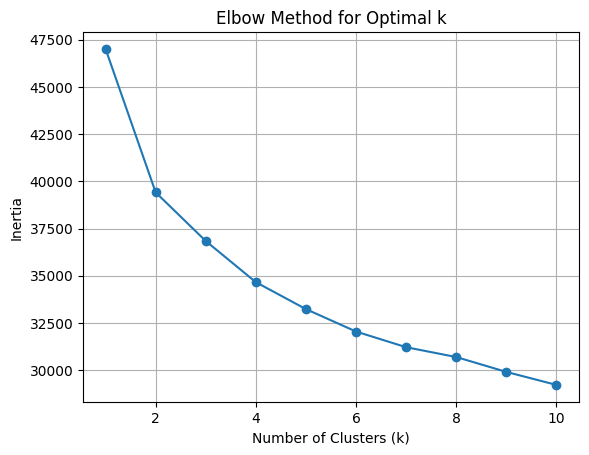

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_13448/2568216483.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessment_df['situation_cluster'] = kmeans.fit_predict(X_scaled)  # Assign cluster labels to the DataFrame


In [ ]:
# Define the list of assessment features
features = [
    'ADULT_EDUCATION_ASSM__C', 'CHILD_CARE_ASSM__C', 'CHILDRENS_EDUCATION_ASSM__C',
    'COMMUNITY_INVOLVEMENT_ASSM__C', 'DISABILITIES_ASSM__C', 'EMPLOYMENT_ASSM__C',
    'FAMILY_SOCIAL_ASSM__C', 'FOOD_ASSM__C', 'HEALTH_CARE_COVERAGE_ASSM__C',
    'HOUSING_ASSM__C', 'INCOME_ASSM__C', 'LEGAL_ASSM__C', 'LIFE_SKILLS_ASSM__C',
    'MENTAL_HEALTH_ASSM__C', 'MOBILITY_ASSM__C', 'PARENTING_SKILLS_ASSM__C',
    'SAFETY_ASSM__C', 'SUBSTANCE_ABUSE_ASSM__C'
]

# Load the assessment data
assessment_df = dfs['new_assessment']

# Extract numeric values from the assessment features and convert them to integers
for col in features:
    assessment_df[col] = assessment_df[col].str.extract(r'^(\d+)')  # Extract numeric values
    assessment_df[col] = assessment_df[col].astype(float).astype('Int64')  # Convert to nullable integer type

# Drop rows with missing values in any of the assessment features
assessment_df = assessment_df.dropna(subset=features)

# Convert the assessment features to standard integer type for processing
assessment_df[features] = assessment_df[features].astype(int)

# Standardize the assessment features using z-score scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(assessment_df[features])

# Use the elbow method to determine the optimal number of clusters for KMeans
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia.append(km.inertia_)  # Append the inertia (sum of squared distances) for each k

# Plot the inertia values to visualize the elbow point
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show() # Optimal k is 4

# Apply KMeans clustering with the optimal number of clusters (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
assessment_df['situation_cluster'] = kmeans.fit_predict(X_scaled)  # Assign cluster labels to the DataFrame

In [34]:
# Calculate mean assessment scores per cluster
cluster_profiles = assessment_df.groupby('situation_cluster')[features].mean()

# Print the mean assessment scores for clusters
print(cluster_profiles)

                   ADULT_EDUCATION_ASSM__C  CHILD_CARE_ASSM__C  \
situation_cluster                                                
0                                 3.219910            1.906787   
1                                 4.135207            3.068273   
2                                 2.987342            1.924051   
3                                 3.051395            1.795888   

                   CHILDRENS_EDUCATION_ASSM__C  COMMUNITY_INVOLVEMENT_ASSM__C  \
situation_cluster                                                               
0                                     3.955656                       3.211765   
1                                     4.156627                       3.800535   
2                                     3.443038                       2.025316   
3                                     3.668135                       1.989721   

                   DISABILITIES_ASSM__C  EMPLOYMENT_ASSM__C  \
situation_cluster                                    

In [35]:
# Flag families with successful program completion
outcomes_df = dfs['new_pmdm'][['EXTERNAL_ID__C', 'REASON_CLOSED__C', 'CLOSURE_REASON__C']].rename(
    columns={'EXTERNAL_ID__C': 'EXTERNAL_ID__C_program'}
)
outcomes_df['successful_exit'] = (
    (outcomes_df['REASON_CLOSED__C'] == 'Completed Program') |
    (outcomes_df['CLOSURE_REASON__C'] == 'Completed Program')
)

In [36]:
# Filter for family leader records
pmdm_df = dfs['new_pmdm']
pmdm_df = pmdm_df[
    (pmdm_df['EX_FAMILY_COLLECTIVE_ENROLLMENT__C'].isna()) &
    (pmdm_df['RECORD_TYPE_NAME__C'] == 'Family_Collective_Enrollment')
]

In [ ]:
# Merge service delivery data with program info
# Drop duplicate records based on specific columns
pmdm_df = pmdm_df.drop_duplicates(subset=[
    'PMDM__STARTDATE__C',
    'PMDM__APPLICATIONDATE__C',
    'LIVING_SITUATION_AT_EXIT__C',
    'LIVING_SITUATION_AT_ENTRY__C'
])

# Merge service delivery data with program info
merged_df = dfs['new_pmdm_servicedelivery'].merge(
    pmdm_df, left_on='EXT_HOUSEHOLD__C', right_on='EXTERNAL_ID__C', how='inner', suffixes=('_service', '_program')
)

# Drop rows with missing values in columns that reflect whether services were delivered
merged_df = merged_df.dropna(subset=['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C', 'SESSION_FORMAT__C'])

In [ ]:
# Process and reshape service records
def prepare_service_df(df, ids):
    df = df[df['EXTERNAL_ID__C_program'].isin(ids)].copy()
    df['service_topic'] = df['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'].apply(lambda x: [s.split(' - ')[0].strip() for s in str(x).split(';') if s.strip() != 'Other'])
    df = df.explode('service_topic')
    df['service_element'] = df.apply(lambda row: f"{row['SESSION_FORMAT__C']}, {row['service_topic']}", axis=1)
    df = df[~df['service_element'].str.contains('nan', na=False)]
    df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(df['PMDM__DELIVERYDATE__C'], errors='coerce')  # Convert the 'PMDM__DELIVERYDATE__C' column to datetime format
    df = df.drop_duplicates(subset=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C', 'service_element'])
    return df

In [39]:
# Get lists of successful and unsuccessful program IDs
if 'EXT_PROGRAM_ENGAGEMENT__C' in assessment_df.columns and 'EXTERNAL_ID__C_program' not in assessment_df.columns:
    assessment_df = assessment_df.rename(columns={'EXT_PROGRAM_ENGAGEMENT__C': 'EXTERNAL_ID__C_program'})

success_ids = outcomes_df[outcomes_df['successful_exit']]['EXTERNAL_ID__C_program'].unique()
fail_ids = outcomes_df[~outcomes_df['successful_exit']]['EXTERNAL_ID__C_program'].unique()

successful_services = prepare_service_df(merged_df.copy(), success_ids)
unsuccessful_services = prepare_service_df(merged_df.copy(), fail_ids)

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_13448/3665254494.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(df['PMDM__DELIVERYDATE__C'], errors='coerce')
/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_13448/3665254494.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(df['PMDM__DELIVERYDATE__C'], errors='coerce')


In [40]:
# Remove outliers based on session count using IQR
def summarize_session_counts(df):
    counts = df.groupby(['EXTERNAL_ID__C_program', 'service_element']).size().reset_index(name='count')
    totals = counts.groupby('EXTERNAL_ID__C_program')['count'].sum().reset_index(name='num_sessions')
    Q1, Q3 = totals['num_sessions'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    valid_ids = totals[totals['num_sessions'] <= upper]['EXTERNAL_ID__C_program']
    return counts[counts['EXTERNAL_ID__C_program'].isin(valid_ids)]

success_counts = summarize_session_counts(successful_services)
failure_counts = summarize_session_counts(unsuccessful_services)

In [41]:
# Compute average sessions per service element by cluster
def get_average_service_profile(service_counts, label):
    merged = service_counts.merge(assessment_df[['EXTERNAL_ID__C_program', 'situation_cluster']], on='EXTERNAL_ID__C_program', how='left')
    profile = merged.groupby(['situation_cluster', 'service_element']).agg(avg_sessions=('count', 'mean')).reset_index()
    profile['avg_sessions'] = profile['avg_sessions'].round(0).astype(int)
    return profile

success_profile = get_average_service_profile(success_counts, 'Successful')
failure_profile = get_average_service_profile(failure_counts, 'Unsuccessful')

In [42]:
# Count number of families in each cluster for success, failure, and total
def count_cluster_families(df):
    return df[['EXTERNAL_ID__C_program']].drop_duplicates().merge(
        assessment_df[['EXTERNAL_ID__C_program', 'situation_cluster']], on='EXTERNAL_ID__C_program', how='left'
    ).groupby('situation_cluster').size().reset_index(name='num_families')

success_cluster_counts = count_cluster_families(successful_services)
failure_cluster_counts = count_cluster_families(unsuccessful_services)
total_cluster_counts = pd.concat([success_cluster_counts, failure_cluster_counts]).groupby('situation_cluster')['num_families'].sum().reset_index(name='total_families')

In [43]:
# Print cluster-wise service recommendations for successful and failed families
def print_service_recommendations(profile, cluster_counts, total_counts, label):
    for cluster in sorted(profile['situation_cluster'].dropna().unique()):
        cluster_services = profile[profile['situation_cluster'] == cluster]
        total_avg_sessions = cluster_services['avg_sessions'].sum()
        n_group = cluster_counts.loc[cluster_counts['situation_cluster'] == cluster, 'num_families'].values[0]
        n_total = total_counts.loc[total_counts['situation_cluster'] == cluster, 'total_families'].values[0]
        print(f"\nCluster {int(cluster)} ({n_group} of {n_total} families {label.lower()}ed, ~{int(total_avg_sessions)} sessions avg):")
        for _, row in cluster_services.sort_values('avg_sessions', ascending=False).iterrows():
            print(f"- {row['avg_sessions']} {row['service_element']}")

In [44]:
print_service_recommendations(success_profile, success_cluster_counts, total_cluster_counts, 'Succeed')


Cluster 0 (159 of 748 families succeeded, ~41 sessions avg):
- 9 Phone call, Family Coaching
- 7 In-person, Family Coaching
- 3 Phone call, Employment navigation
- 3 Video conference, Family Coaching
- 3 Phone call, Housing services
- 2 Video conference, Higher Education
- 2 In-person, Housing services
- 2 Phone call, Higher Education
- 1 In-person, Child services beyond childcare
- 1 Phone call, Family engagement
- 1 Phone call, Childcare
- 1 In-person, Childcare
- 1 Phone call, Child services beyond childcare
- 1 In-person, Legal aid
- 1 In-person, Higher Education
- 1 In-person, Family engagement
- 1 In-person, Employment navigation
- 1 Video conference, Legal aid

Cluster 1 (167 of 461 families succeeded, ~43 sessions avg):
- 9 Phone call, Family Coaching
- 6 In-person, Family Coaching
- 4 Video conference, Family Coaching
- 3 Phone call, Employment navigation
- 3 Phone call, Housing services
- 2 In-person, Employment navigation
- 1 Phone call, Higher Education
- 1 Video conferenc

In [45]:
print_service_recommendations(failure_profile, failure_cluster_counts, total_cluster_counts, 'Fail')


Cluster 0 (589 of 748 families failed, ~40 sessions avg):
- 6 Phone call, Family Coaching
- 4 In-person, Family Coaching
- 4 Video conference, Family Coaching
- 3 Phone call, Employment navigation
- 2 Video conference, Higher Education
- 2 Phone call, Housing services
- 2 Video conference, Housing services
- 2 In-person, Housing services
- 2 In-person, Family engagement
- 1 In-person, Legal aid
- 1 In-person, Mental health services
- 1 Phone call, Child services beyond childcare
- 1 Phone call, Childcare
- 1 In-person, Childcare
- 1 Phone call, Family engagement
- 1 Phone call, Higher Education
- 1 In-person, Higher Education
- 1 Phone call, Legal aid
- 1 Phone call, Mental health services
- 1 Video conference, Employment navigation
- 1 In-person, Employment navigation
- 1 In-person, Child services beyond childcare

Cluster 1 (294 of 461 families failed, ~37 sessions avg):
- 6 Phone call, Family Coaching
- 4 In-person, Family Coaching
- 4 In-person, Family engagement
- 3 Phone call, E